# **General Bayes** : Linear regression application

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm 
import pymc.math as pm_math
import seaborn as sns

## **Data generation**

Linear model : $$y_i = \theta x_i + \epsilon_{i}, \epsilon \sim \mathcal{N}(0, \sigma^2), \theta \in \mathbb{R} $$

On peut utiliser differents estimateurs : 

$$
\hat{\theta}_{MLE}
=
\frac{\sum_{i=1}^{n} x_i y_i}
     {\sum_{i=1}^{n} x_i^2}
$$


In [71]:
def generate_linear_data(X : np.array, coeff : float, sigma : float):
    n = X.shape[0]
    noise = np.random.normal(loc = 0, scale = sigma, size = n)
    return coeff*X + noise

def compute_mle(x : np.array , y : np.array):
    return (x.T)@y/np.sum(x**2)


theta MLE : 0.8535576163813662
Theta : 0.75


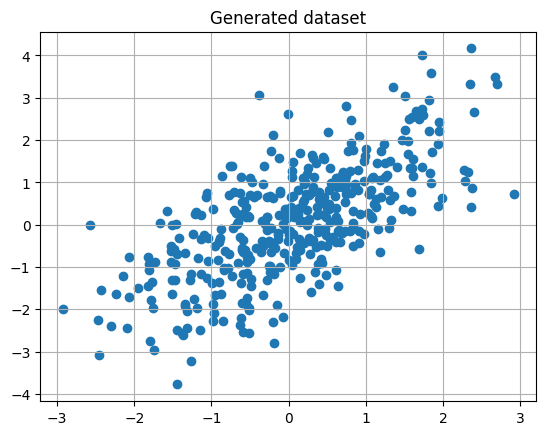

In [72]:
sigma2 = 1
theta = 0.75

X = np.random.normal(loc = 0, scale = sigma2, size = 400)
Y = generate_linear_data(X, theta, sigma2)

fig, ax = plt.subplots()
ax.scatter(X, Y)
ax.set_title("Generated dataset")
ax.grid()

print(f"theta MLE : {compute_mle(X, Y)}")
print(f"Theta : 0.75")

## **Linear Regression**

### **Classic Bayes** 

$$
p(y \mid \theta)
=
(2\pi\sigma^2)^{-n/2}
\exp\!\left(
-\frac{1}{2\sigma^2}
\sum_{i=1}^{n}
(y_i - \theta x_i)^2
\right).
$$


On suppose un prior gaussien :

$$
\theta \sim \mathcal{N}(0,\tau^2),
$$



Donc le posterieur : 
$$
\theta \mid y \sim \mathcal{N}(\mu_n, \Sigma_n)
$$

où

$$
\Sigma_n
=
\left(
\frac{\sum_{i=1}^{n} x_i^2}{\sigma^2}
+
\frac{1}{\tau^2}
\right)^{-1}
$$

et

$$
\mu_n
=
\Sigma_n
\frac{\sum_{i=1}^{n} x_i y_i}{\sigma^2}.
$$

Ainsi que l'estimateur du maximum de vraisemblance : 



In [73]:
def compute_gaussian_posterior(x : np.array, y : np.array, sigma2 : float, tau : float):

    sigma_n = 1/(np.sum(x**2)/sigma2 + 1/(tau**2))
    mu_n = sigma_n*(x.T@y)/sigma2

    return mu_n, sigma_n

compute_gaussian_posterior(X,Y,1,2)

(np.float64(0.8530857410695636), np.float64(0.0022113343153244446))

### **General Bayes**

On utilise un prior gaussien : 

$$
\theta \sim \mathcal{N}(0,\tau^2),
$$

Dans le cas du bayésien généralisé : 

$$
q(\theta | y_{1:n}) \propto e^{-\frac{\theta^2}{2\tau^2} - \eta L_n(\theta)}
$$

$$
q(\theta | y_{1:n} ) \propto e^{- (\frac{\theta^2}{2\tau^2} + \eta L_n(\theta))}
$$


On connait la densité posterieure à une constante de normalisation près, on va utiliser l'algorithme de metropolis-hasting pour pouvoir approximer la densité, on utilise KDE. 


In [101]:
def cum_loss_L1(x, y, theta):
    return pm_math.sum(pm_math.abs(y - x*theta))

def cum_loss_L2(x, y, theta):
    return pm_math.sum((y - x*theta)**2)

def MHSample(n_sample : int, X : np.array , Y : np.array, tau : float, eta : float , loss):
    
    with pm.Model() as model:
        theta = pm.Normal("theta", mu=0, sigma=tau)
        pm.Potential("loss", -eta * loss(X, Y, theta))
        
        step = pm.Metropolis()
        trace = pm.sample(n_sample, tune=1000, step=step, cores=1, chains=2, progressbar=True)

    rhat = az.rhat(trace, var_names=["theta"])
    ess = az.ess(trace, var_names=["theta"])
    print("R-hat:", rhat["theta"].values)
    print("Effective sample size (ESS):", ess["theta"].values)
    
    return trace


### **Effect of $\eta$**

On fixe un prior gaussien puis on sample avec différentes valeurs de éta.

Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Generating sample for eta : 0.1


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


R-hat: 1.002888572444443
Effective sample size (ESS): 1471.329332512347
Generating sample for eta : 0.3


Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


R-hat: 1.0052022915082275
Effective sample size (ESS): 1183.794344032085
Generating sample for eta : 0.5


Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


R-hat: 1.002259382696297
Effective sample size (ESS): 1117.9889194421119
Generating sample for eta : 0.7


Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


R-hat: 1.0011134425913975
Effective sample size (ESS): 1164.7093980014918
Generating sample for eta : 0.9


Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


R-hat: 1.0006043007838465
Effective sample size (ESS): 1182.2524038762551


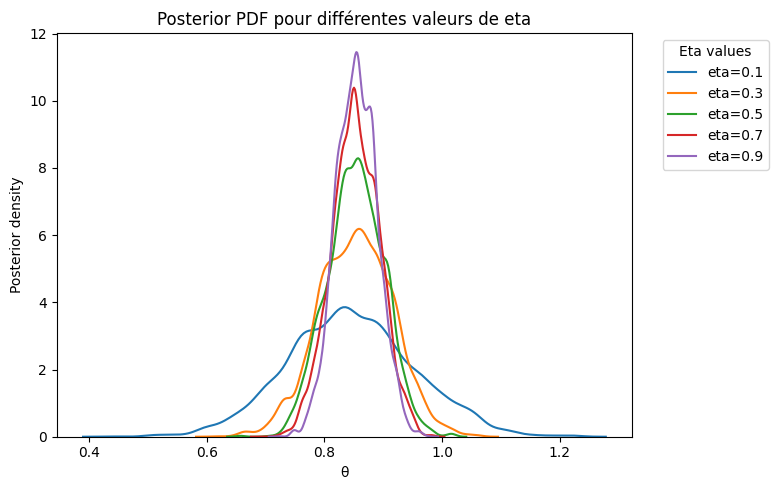

In [104]:
n_sample = 5000
tau = 2

etas = [0.1, 0.3, 0.5, 0.7, 0.9]
samples = []

for eta in etas:
    print(f"Generating sample for eta : {eta}")
    samples.append(MHSample(n_sample, X, Y, tau, eta, cum_loss_L2))


plt.figure(figsize=(8,5))

for i, eta in enumerate(etas):
    theta_samples = samples[i].posterior["theta"].values.flatten()
    sns.kdeplot(theta_samples, label=f"eta={eta}", fill=False)


plt.xlabel("θ")
plt.ylabel("Posterior density")
plt.title("Posterior PDF pour différentes valeurs de eta")
plt.legend(title="Eta values", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

Au fur et à mesure que l'on se rapproche de eta = 1, on obtient le modèle de regression linéaire bayesiennes classiques. 

### Effet de la loss

On fixe un posterieur gaussien puis on compare la loss $L_1$ ainsi que la loss $L_2$.

Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sequential sampling (2 chains in 1 job)
Metropolis: [theta]


/home/perann/miniconda3/envs/dl_venv/lib/python3.12/site-packages/rich/live.py:260: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

R-hat: 1.0018107530405882
Effective sample size (ESS): 1124.6291285996779


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


R-hat: 1.001090088101433
Effective sample size (ESS): 1313.721770482501


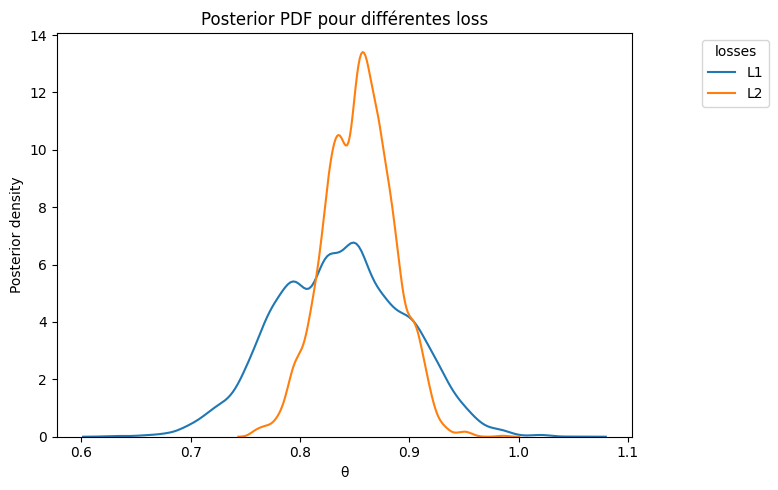

In [108]:
eta = 1 
tau = 2 
samples = []
n_sample = 5000

losses = [cum_loss_L1, cum_loss_L2]

for loss in losses:
    samples.append(MHSample(n_sample, X, Y, tau, eta, loss))
    

plt.figure(figsize=(8,5))

for i, loss in enumerate(losses):
    theta_samples = samples[i].posterior["theta"].values.flatten()
    sns.kdeplot(theta_samples, label=f"L{i+1}", fill=False)


plt.xlabel("θ")
plt.ylabel("Posterior density")
plt.title("Posterior PDF pour différentes loss")
plt.legend(title="losses", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()